# Proof of Concept for all-active models as starting point for selective optimizations

In [1]:
from ateamopt.utils import utility
from ateamopt.analysis.optim_analysis import Optim_Analyzer
from ateamopt.model_parameters import AllActive_Model_Parameters as ParamsHandler
from ateamopt.bpopt_evaluator import Bpopt_Evaluator
import pprint
import os
import logging
import man_opt.utils as man_utils
from allensdk.core.cell_types_cache import CellTypesCache
import bluepyopt as bpopt
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import efel

%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

pp = pprint.PrettyPrinter(indent=4)
rev_potential = utility.rev_potential
section_map = utility.bpopt_section_map

/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Pick an optimized mouse neuron model

In [2]:
cell_id = 483101699 # Pick an optimized mouse PC
ctc = CellTypesCache()

# Get the optimized model
model_param_file = f'{cell_id}_fit.json'
man_utils.getModel(cell_id, download_path = model_param_file)

# Get morphology restruction
morph_path = f'{cell_id}.swc'
ctc.get_reconstruction(cell_id, morph_path)

param_handler = ParamsHandler(cell_id, swc_path = morph_path, released_aa_model_path = model_param_file)
model_params_bpopt = param_handler.get_release_params(section_map, rev_potential)
repeat_params = ['Ra', 'g_pas', 'e_pas'] # parameters that are uniform across the sections
idx_remove = []
seen_params = []

# Convert the parameter file to a BluePyOpt ingestible format. 
for i, param_dict in enumerate(model_params_bpopt):
    if param_dict['param_name'] in repeat_params and param_dict['param_name'] not in seen_params:
        param_dict['sectionlist'] = 'all'
        seen_params.append(param_dict['param_name'])
    elif param_dict['param_name'] in seen_params:
        idx_remove.append(i)
        
model_params_bpopt = [param_dict for j, param_dict in enumerate(model_params_bpopt) if j not in idx_remove]
pp.pprint(model_params_bpopt)

[   {   'dist_type': 'uniform',
        'mech': 'Im',
        'param_name': 'gbar_Im',
        'sectionlist': 'basal',
        'type': 'range',
        'value': 0.000264119004407},
    {   'dist_type': 'uniform',
        'mech': 'Ih',
        'param_name': 'gbar_Ih',
        'sectionlist': 'somatic',
        'type': 'range',
        'value': 6.46347368582e-05},
    {   'dist_type': 'uniform',
        'param_name': 'e_pas',
        'sectionlist': 'all',
        'type': 'section',
        'value': -95.944096559},
    {   'dist_type': 'uniform',
        'param_name': 'cm',
        'sectionlist': 'axonal',
        'type': 'section',
        'value': 4.48091879054},
    {   'dist_type': 'uniform',
        'mech': 'CaDynamics',
        'param_name': 'decay_CaDynamics',
        'sectionlist': 'axonal',
        'type': 'range',
        'value': 350.57849732},
    {   'dist_type': 'uniform',
        'mech': 'Ca_LVA',
        'param_name': 'gbar_Ca_LVA',
        'sectionlist': 'somatic',
       

## Add dendritic constraints

Unpublished data from Adam Shai [Shai et al, 2015]

![](bAP.png)

We will use dend vs soma amplitude at 100 and 300 microns away.
@100 microns and 300 microns dend/soma ~ 0.8 and 0.5 respectively.
Let's add these recordings for the maximal amplitude recording - LongDC 47

In [3]:
# Stimulus protocols and ephys features extracted using eFEL.
protocols_path = 'config/protocols.json'
features_path = 'config/features.json'

protocols = utility.load_json(protocols_path)
features = utility.load_json(features_path)

# Define dendritic features and set up recording.
dend_locations = [100, 300]
select_proto_name = 'LongDC_55'
select_feature_name = 'AP_amplitude_from_voltagebase'
reduced_feature_set = [select_feature_name, 'voltage_base', 'AP_width', 'Spikecount']

dend_to_soma_ratio = {100 : 0.8, 300 : 0.5}

for proto_name, proto_def in protocols.items():
    if proto_name == select_proto_name:
        proto_def['extra_recordings'] = []
        for i, dend_location in enumerate(dend_locations):
            proto_def['extra_recordings'].append(
            {
                'var' : 'v',
                'somadistance' : dend_location,
                'type' : 'somadistance',
                'name' : 'dend%s'%i,
                'seclist_name' : 'apical'
            }
            )
            
            select_feature_mean, select_feature_std = features[proto_name]['soma'][select_feature_name]
            features[proto_name]['dend%s'%i] = {
                select_feature_name : [dend_to_soma_ratio[dend_location]*select_feature_mean,
                                      select_feature_std]
                
            }

protocols_new = {proto_name : proto_def for proto_name, proto_def in protocols.items() if proto_name == select_proto_name}
features_new = {proto_name : feature_def for proto_name, feature_def in features.items() if proto_name == select_proto_name}
features_new[select_proto_name]['soma'] = {feat_name : feat_stat for feat_name, feat_stat 
                            in features_new[select_proto_name]['soma'].items() if feat_name in reduced_feature_set}         
pp.pprint(protocols_new)
pp.pprint(features_new)

{   'LongDC_55': {   'extra_recordings': [   {   'name': 'dend0',
                                                 'seclist_name': 'apical',
                                                 'somadistance': 100,
                                                 'type': 'somadistance',
                                                 'var': 'v'},
                                             {   'name': 'dend1',
                                                 'seclist_name': 'apical',
                                                 'somadistance': 300,
                                                 'type': 'somadistance',
                                                 'var': 'v'}],
                     'stimuli': [   {   'amp': 0.269999994584,
                                        'amp_end': 0.269999994584,
                                        'delay': 270.0,
                                        'duration': 999.9949999999999,
                                        'stim_end'

## Add relaxation around the optimized parameters

In [4]:
skip_params = [] # reoptimize all parameters
tolerance = 0.5

# create bounds for these selected parameters
for param_dict in model_params_bpopt:
    if param_dict['param_name'] not in skip_params:
        param_dict['bounds'] = [param_dict['value'] - abs(param_dict['value'])*tolerance, 
                                param_dict['value'] + abs(param_dict['value'])*tolerance]
        del param_dict['value']

pp.pprint(model_params_bpopt)

bpopt_mech = utility.load_json('config/mechanism.json')

[   {   'bounds': [0.0001320595022035, 0.0003961785066105],
        'dist_type': 'uniform',
        'mech': 'Im',
        'param_name': 'gbar_Im',
        'sectionlist': 'basal',
        'type': 'range'},
    {   'bounds': [3.23173684291e-05, 9.695210528730001e-05],
        'dist_type': 'uniform',
        'mech': 'Ih',
        'param_name': 'gbar_Ih',
        'sectionlist': 'somatic',
        'type': 'range'},
    {   'bounds': [-143.9161448385, -47.9720482795],
        'dist_type': 'uniform',
        'param_name': 'e_pas',
        'sectionlist': 'all',
        'type': 'section'},
    {   'bounds': [2.24045939527, 6.72137818581],
        'dist_type': 'uniform',
        'param_name': 'cm',
        'sectionlist': 'axonal',
        'type': 'section'},
    {   'bounds': [175.28924866, 525.86774598],
        'dist_type': 'uniform',
        'mech': 'CaDynamics',
        'param_name': 'decay_CaDynamics',
        'sectionlist': 'axonal',
        'type': 'range'},
    {   'bounds': [0.002548702

## Save configuration

In [5]:
config_dir = "config_dend"
for config, config_file in zip([protocols_new, features_new, model_params_bpopt, bpopt_mech], 
                               ['protocols.json', 'features.json', 'parameters.json', 'mechanism.json']):
    config_file_path = os.path.join(config_dir, config_file)
    utility.save_json(config_file_path, config)

## Launch a new optimization using the config files

$ launch_optimjob --input_json job_config.json

## Simulate ephys recording at soma and apical dendrite

In [6]:
optimized_parameter_path = os.path.join(config_dir, "optimized_parameters.json")
protocol_path = os.path.join(config_dir, "protocols.json")
mech_path = os.path.join(config_dir, "mechanism.json")
feature_path = os.path.join(config_dir, "features.json")

eval_handler = Bpopt_Evaluator(protocol_path, feature_path, morph_path, optimized_parameter_path, mech_path)
evaluator = eval_handler.create_evaluator()
opt = bpopt.optimisations.DEAPOptimisation(evaluator=evaluator)
select_run_protocols = []
fitness_protocols = opt.evaluator.fitness_protocols

select_stim_key = 'LongDC_55'
recording_protocols = utility.load_json(protocol_path)
stim_start = recording_protocols[select_stim_key]['stimuli'][0]['delay']
stim_end = recording_protocols[select_stim_key]['stimuli'][0]['stim_end']

for protocol in fitness_protocols.values():
    if protocol.name == select_stim_key:
        select_run_protocols.append(protocol)
        
new_responses = evaluator.run_protocols(
        select_run_protocols,
        param_values={}) 

old_parameters = utility.load_json(os.path.join("config_dend", "old_parameters.json"))
eval_handler.param_path = os.path.join("config", "parameters.json")
evaluator = eval_handler.create_evaluator()
old_responses = evaluator.run_protocols(
        select_run_protocols,
        param_values=old_parameters) 

## Detect spike times, calculate spike shape and dendritic bAP

In [7]:
def get_spike_times(time, voltage, delay, stim_end):    
    sweeps = []
    spike_features = ['peak_time']

    # Prepare sweep for eFEL
    sweep = {}
    sweep['T'] = time
    sweep['V'] = voltage
    sweep['stim_start'] = [delay]
    sweep['stim_end'] = [stim_end]
    sweeps.append(sweep)

    # Extract experimental spike times
    feature_results = efel.getFeatureValues(sweeps, spike_features)
    return feature_results[0]['peak_time']

new_soma_response = new_responses["{}.soma.v".format(select_stim_key)]["voltage"].values
old_soma_response = old_responses["{}.soma.v".format(select_stim_key)]["voltage"].values

new_dend_response = new_responses["{}.dend0.v".format(select_stim_key)]["voltage"].values
old_dend_response = old_responses["{}.dend0.v".format(select_stim_key)]["voltage"].values

time_new, time_old = new_responses["{}.soma.v".format(select_stim_key)]["time"].values, old_responses["{}.soma.v".format(select_stim_key)]["time"].values

new_spike_times = get_spike_times(time_new, new_soma_response, stim_start, stim_end)
old_spike_times = get_spike_times(time_old, old_soma_response, stim_start, stim_end)

select_spike_time_new, select_spike_time_old = new_spike_times[1], old_spike_times[1]

## Spike shape and bAP comparison between base model and reoptimized model with dendritic constraints

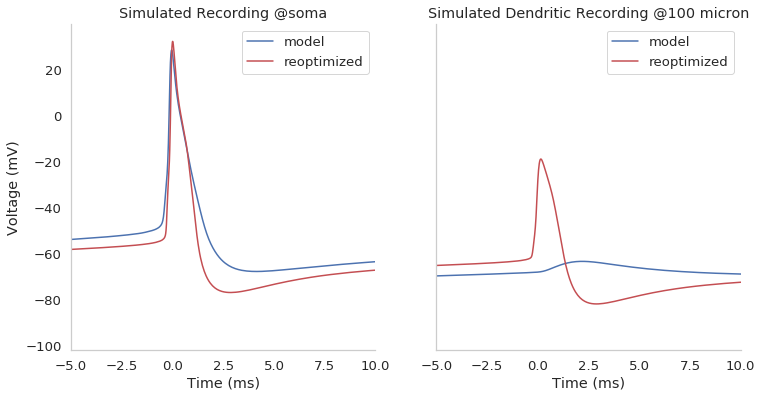

In [10]:
sns.set(style = "whitegrid", font_scale=1.2)
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax[0].plot(time_old - select_spike_time_old, old_soma_response, color = "b", label = "model")
ax[0].plot(time_new - select_spike_time_new, new_soma_response, color = "r", label = "reoptimized")
ax[0].set_ylabel("Voltage (mV)")
ax[0].set_title("Simulated Recording @soma")
ax[1].plot(time_old - select_spike_time_old, old_dend_response, color = "b", label = "model")
ax[1].plot(time_new - select_spike_time_new, new_dend_response, color = "r", label = "reoptimized")
ax[1].set_title("Simulated Dendritic Recording @100 micron")
for ax_ in ax:
    ax_.set_xlim([-5, 10])
    ax_.legend()
    ax_.set_xlabel("Time (ms)")
    ax_.grid(False)
    sns.despine(ax=ax_)
plt.show()